In [10]:
import os
import pandas as pd
import re
import numpy as np
import os
import keras
import urllib.request
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from collections import Counter
from konlpy.tag import Mecab

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.initializers import Constant
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, GRU, Dense
from tensorflow.keras.models import Model

%matplotlib inline
#!pip install sentencepiece

In [93]:
_dir = '~/aiffel/DLThon' 
data_dir = os.path.join(_dir, 'train.csv')

df = pd.read_csv(data_dir)

#data shuffle
df = df.sample(frac=1)

print(len(df))
df.head(3)

3950


,idx,class,conversation
234,234,직장 내 괴롭힘 대화,아니 글쎄 씨가\n어머 사원 그렇게 안 봤는데 대박이네\n무슨 얘기하고 계세요?\n...
1345,1345,갈취 대화,민선아 나 요즘 나 아이돌준비하느라 돈이 너무 많이나가서 그런데 나 5만원만 빌려줄...
665,665,기타 괴롭힘 대화,장애인이면 다인가? 왜 무조건 배려를 받으려고해?\n도움이 필요하니까 그런 거 잖아...


In [94]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

def check_class(it):
    if '협박' in it:
        return 0
    elif '갈취' in it:
        return 1
    elif '직장 내 괴롭힘' in it:
        return 2
    elif '기타 괴롭힘' in it:
        return 3
    else:
        return 4

df['data'] = df['conversation'].apply(lambda it : preprocess_sentence(it))
df['label'] = df['class'].apply(lambda it: check_class(it))


df.head(3)

,idx,class,conversation,data,label
234,234,직장 내 괴롭힘 대화,아니 글쎄 씨가\n어머 사원 그렇게 안 봤는데 대박이네\n무슨 얘기하고 계세요?\n...,아니 글쎄 씨가 어머 사원 그렇게 안 봤는데 대박이네 무슨 얘기하고 계세요 ? 아 ...,2
1345,1345,갈취 대화,민선아 나 요즘 나 아이돌준비하느라 돈이 너무 많이나가서 그런데 나 5만원만 빌려줄...,민선아 나 요즘 나 아이돌준비하느라 돈이 너무 많이나가서 그런데 나 만원만 빌려줄 ...,1
665,665,기타 괴롭힘 대화,장애인이면 다인가? 왜 무조건 배려를 받으려고해?\n도움이 필요하니까 그런 거 잖아...,장애인이면 다인가 ? 왜 무조건 배려를 받으려고해 ? 도움이 필요하니까 그런 거 잖...,3


In [95]:
print(df.isnull().sum())

idx             0
class           0
conversation    0
data            0
label           0
dtype: int64


협박           896
갈취           981
직장 내 괴롭힘     979
기타 괴롭힘      1094
Name: idx, dtype: int64


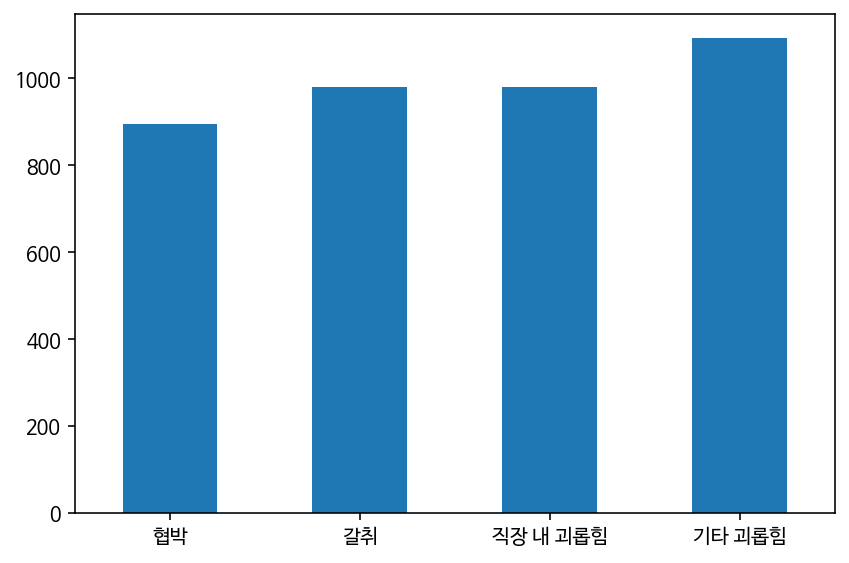

In [60]:
group_count = df.groupby("label").count().iloc[:,0]
group_count.index = ['협박', '갈취', '직장 내 괴롭힘',  '기타 괴롭힘']

print(group_count)

group_count.plot(kind="bar")
plt.xticks(rotation = 360)
plt.tight_layout()
plt.show()

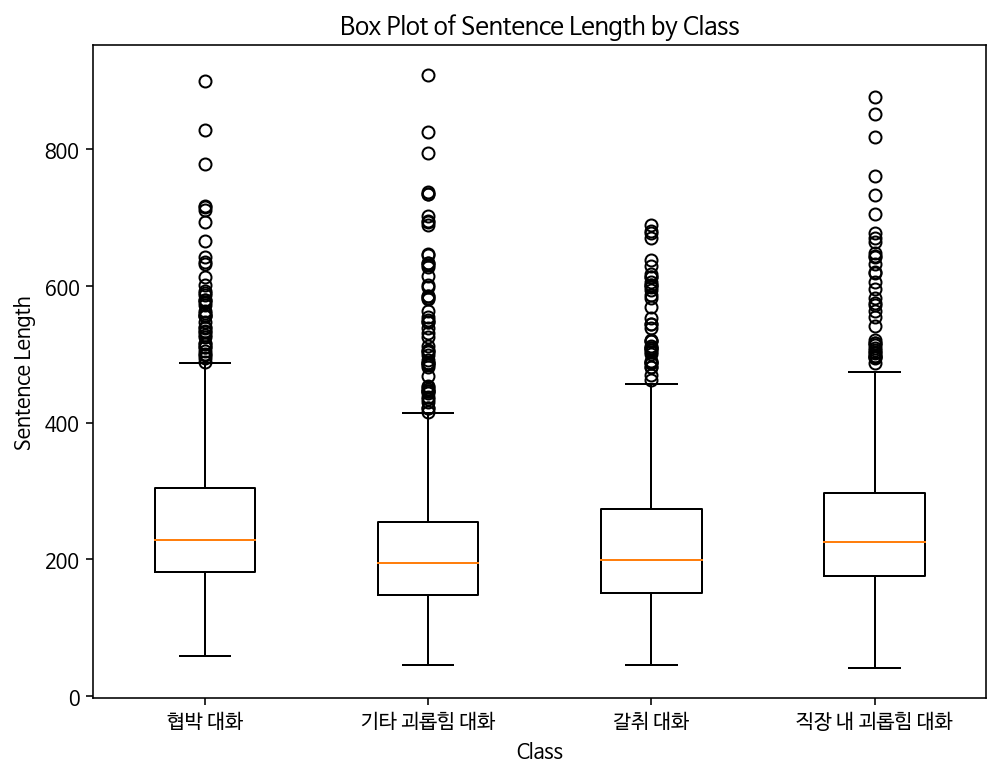

In [61]:
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

label = df["class"]
sentence = df["data"]

# 데이터프레임 생성
df_boxplot = pd.DataFrame({"Class": label, "Sentence Length": [len(s) for s in sentence]})

# 상자 그림 그리기
plt.figure(figsize=(8, 6))
plt.boxplot([df_boxplot[df_boxplot["Class"]==c]["Sentence Length"] for c in df_boxplot["Class"].unique()], labels=df_boxplot["Class"].unique())
plt.xlabel("Class")
plt.ylabel("Sentence Length")
plt.title("Box Plot of Sentence Length by Class")
plt.show()

문장의 최단 길이: 41
문장의 최장 길이: 909
문장의 평균 길이: 235


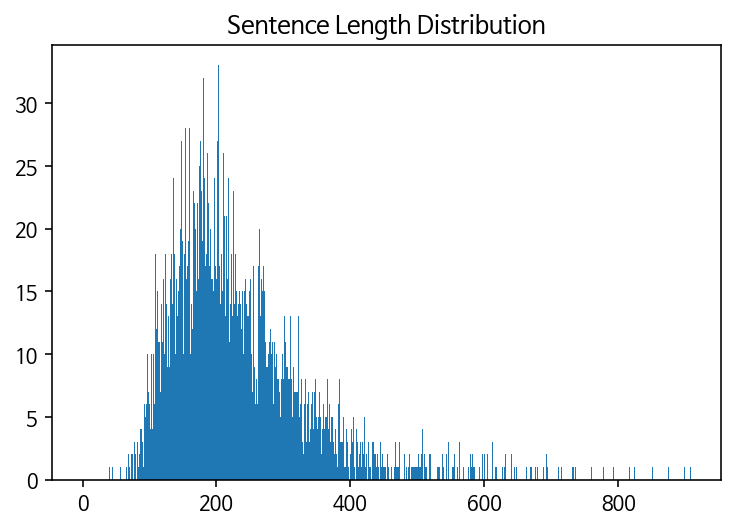

In [64]:
#최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이 분포를 막대그래프로 표현
min_len = 999
max_len = 0
sum_len = 0

raw = []
for sent in df['data']:
  raw.append(sent)

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [120]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

def load_data(train_data, num_words = num_words):
  #데이터 중복제거
  train_data.drop_duplicates(subset=['data'], inplace=True)
    
  #NaN 결측치 제거
  train_data = train_data.dropna(how = 'any')

  #토큰화 및 불용어 제거
  X_train = []
  for sentence in df['data']:
    temp_X = tokenizer.morphs(sentence)   # 한국어 토크나이저로 토큰화
    temp_X = [word for word in temp_X if not word in stopwords]  # 불용어(Stopwords) 제거
    X_train.append(temp_X)

  words = np.concatenate(X_train).tolist()
  counter = Counter(words)
  counter = counter.most_common(num_words-4)
  vocab = ['', '', '', ''] + [key for key, _ in counter]
  word_to_index = {word:index for index, word in enumerate(vocab)}

  #사전word_to_index 구성
  def wordlist_to_indexlist(wordlist):
      return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

  X_train = list(map(wordlist_to_indexlist, X_train))

  return X_train, np.array(list(df['label'])), word_to_index

X_train, y_train, word_to_index = load_data(df)

#index_to_word생성
index_to_word = {index:word for word, index in word_to_index.items()}

#", , "는 관례적으로 딕셔너리 맨 앞에 넣어줌
index_to_word[0]="<pad>"  # 패딩용 단어
index_to_word[1]="<bos>"  # 문장의 시작지점
index_to_word[2]="<unk>"  # 사전에 없는(Unknown) 단어


#딕셔너리를 {텍스트:인덱스}구조로 변환
word_to_index = {word:index for index, word in index_to_word.items()}


#패딩 추가
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value= 0,
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=500)  ##적절한 최대 문장 길이(maxlen) 지정: (평균 + 4*표준편차)로 가정 => 67

print(x_train.shape)  #(3845, 500)

(3845, 500)


In [121]:
#validation set 분리
x_val = x_train[:400]
y_val = y_train[:400]

partial_x_train = x_train[400:]
partial_y_train = y_train[400:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(3445, 500)
(3445,)


Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_39 (Embedding)     (None, 500, 100)          1000000   
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 500, 32)           9632      
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 250, 32)           0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 250, 32)           0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 8000)              0         
_________________________________________________________________
dense_75 (Dense)             (None, 32)                256

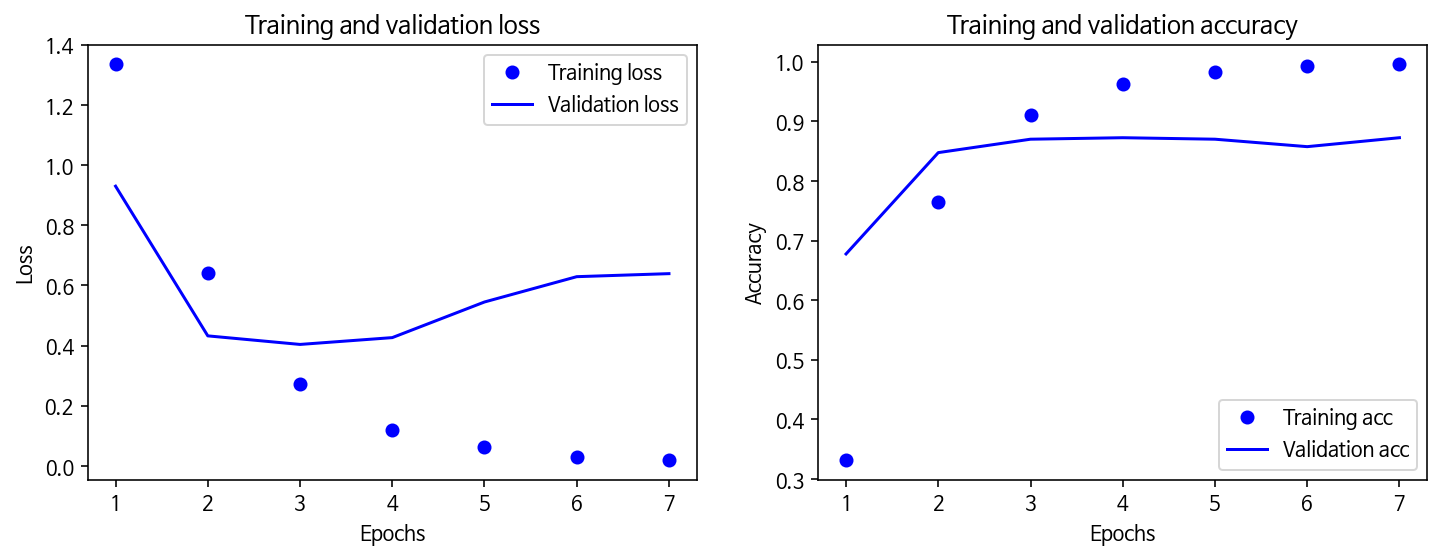

In [122]:
vocab_size = 10000
word_vector_dim = 100


from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

inputs = keras.Input(shape=(500,), dtype="int64")
x = layers.Embedding(vocab_size, word_vector_dim)(inputs)
x = layers.Conv1D(32, 3, activation='relu', padding = "same")(x)
x = layers.MaxPool1D(2, padding = "same")(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

#모델학습
callbacks = [
    keras.callbacks.EarlyStopping(monitor = "val_loss", verbose = 1, patience = 4),
    keras.callbacks.ModelCheckpoint("dl_15245keras",
                                    save_best_only=True)
]

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=16,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks = callbacks)


#history변수에 저장된 매 epoch rain/validation loss, accuracy 그래프 그리기

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))

#training & validation loss graph

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"입니다
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#training & validation Accuracy graph
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()